In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import json
from tqdm import tqdm
import yaml # Để đọc file config

print("Import thư viện thành công!")

# --- HÀM parse_skeleton_file (Phiên bản V4 - Khoan dung hơn với file cắt cụt) ---
def parse_skeleton_file(filepath):
    """Đọc và phân tích file .skeleton (V4 - Cố gắng đọc tối đa frame hợp lệ)."""
    try:
        with open(filepath, 'r') as f:
            lines = f.readlines()

        if not lines:
            # tqdm.write(f"\n[Lỗi Parse] File {filepath} trống.") # Tắt bớt log
            return None

        # Đọc số frame tổng dự kiến
        try:
            expected_frame_count = int(lines[0].strip())
        except (ValueError, IndexError):
             tqdm.write(f"\n[Lỗi Parse] File {filepath} không đọc được frame count.")
             return None

        frames_data = [] # List để chứa các frame đọc được
        line_idx = 1
        actual_frames_read = 0 # Số frame thực sự đã duyệt qua

        while line_idx < len(lines): # Thay vòng lặp for bằng while để xử lý linh hoạt hơn
            current_frame_start_line = line_idx
            # --- Đọc Header Frame ---
            try:
                # Đọc body count
                if line_idx >= len(lines): break # Hết file
                body_count_str = lines[line_idx].strip()
                if not body_count_str: break # Dòng trống, coi như hết file
                body_count = int(body_count_str)
                line_idx += 1

                # Nếu frame không có body, nhảy qua các dòng ước lượng
                if body_count == 0:
                    actual_frames_read += 1
                    continue # Chuyển sang lần lặp while tiếp theo (đầu frame sau)

                # --- Đọc Body Đầu Tiên ---
                # Đọc body info
                if line_idx >= len(lines): break
                line_idx += 1 # Bỏ qua body info

                # Đọc joint count
                if line_idx >= len(lines): break
                joint_count_str = lines[line_idx].strip()
                if not joint_count_str: break
                joint_count = int(joint_count_str)
                line_idx += 1

                # Kiểm tra số dòng còn lại cho khớp
                if line_idx + joint_count > len(lines):
                    # tqdm.write(f"\n[Cảnh báo Parse] File {filepath}: Frame {actual_frames_read} bị cắt cụt, thiếu dòng khớp. Dừng đọc.") # Tắt bớt log
                    break # Dừng vòng lặp while

                # Đọc các khớp của body đầu tiên
                current_body_joints = []
                valid_body = True
                for k in range(joint_count):
                    try:
                        joint_info = lines[line_idx].strip().split()
                        joint_data = [float(coord) for coord in joint_info[:3]]
                        current_body_joints.append(joint_data)
                        line_idx += 1
                    except (ValueError, IndexError):
                         # tqdm.write(f"\n[Cảnh báo Parse] File {filepath}: Lỗi đọc khớp {k} frame {actual_frames_read}. Bỏ qua body.") # Tắt bớt log
                         line_idx += (joint_count - k) # Bỏ qua các dòng khớp còn lại của body này
                         valid_body = False
                         break # Dừng đọc khớp của body này

                # Nếu body đầu tiên đọc thành công
                if valid_body:
                    # Đảm bảo 25 khớp
                    while len(current_body_joints) < 25:
                        current_body_joints.append([0.0, 0.0, 0.0])
                    frames_data.append(np.array(current_body_joints[:25])) # Thêm frame hợp lệ

                # --- Bỏ qua các body còn lại (nếu có) ---
                for j in range(1, body_count): # Bắt đầu từ body thứ 2
                    # Ước lượng số dòng cần bỏ qua cho mỗi body thừa: 1 (bodyInfo) + 1 (jointCount) + joint_count (joints)
                    # Giả sử joint_count thường là 25
                    lines_to_skip = 1 + 1 + 25
                    line_idx += lines_to_skip
                    if line_idx >= len(lines): break # Thoát nếu hết file khi đang bỏ qua

                actual_frames_read += 1 # Đã xử lý xong (hoặc bỏ qua) 1 frame

            except (ValueError, IndexError, Exception) as e_frame:
                # Nếu có lỗi khi đọc header của frame (vd: body_count không phải số)
                # tqdm.write(f"\n[Cảnh báo Parse] File {filepath}: Lỗi đọc header frame {actual_frames_read}: {e_frame}. Dừng đọc file.") # Tắt bớt log
                break # Dừng vòng lặp while

        # --- Trả về kết quả ---
        if frames_data: # Nếu đọc được ít nhất 1 frame hợp lệ
            if actual_frames_read < expected_frame_count:
                 # tqdm.write(f"\n[Cảnh báo Parse] File {filepath}: Chỉ đọc được {len(frames_data)}/{expected_frame_count} frames do file lỗi/cắt cụt.") # Tắt bớt log
                 pass
            return np.array(frames_data)
        else:
            # tqdm.write(f"\n[Lỗi Dataset] File {filepath} không đọc được frame hợp lệ nào.") # Tắt bớt log
            return None # Trả về None nếu không đọc được frame nào

    except Exception as e:
        # tqdm.write(f"\n[Lỗi Dataset] Lỗi nghiêm trọng khi đọc file {filepath}: {e}") # Tắt bớt log
        return None
# --- KẾT THÚC HÀM parse_skeleton_file ---

# --- SAO CHÉP HÀM plot_skeleton (Giữ nguyên) ---
def plot_skeleton(joints_data, frame_num):
    x = joints_data[:, 0]; y = joints_data[:, 1]
    connections = [(0, 1), (1, 20), (20, 2), (2, 3), (20, 4), (4, 5), (5, 6), (6, 7), (7, 21), (7, 22), (20, 8), (8, 9), (9, 10), (10, 11), (11, 23), (11, 24), (0, 12), (12, 13), (13, 14), (14, 15), (0, 16), (16, 17), (17, 18), (18, 19)]
    plt.figure(figsize=(6, 8)); plt.scatter(x, y, c='red', s=40)
    for (start_joint, end_joint) in connections:
        if start_joint < len(x) and end_joint < len(x): plt.plot([x[start_joint], x[end_joint]], [y[start_joint], y[end_joint]], 'b-')
    plt.title(f"Khung xương 2D - Frame {frame_num}"); plt.xlabel("Tọa độ X"); plt.ylabel("Tọa độ Y"); plt.gca().set_aspect('equal', adjustable='box'); plt.show()



Import thư viện thành công!


In [23]:
PROJECT_ROOT_DIR = r"D:\code_etc\Python\_File_code\Pose_estimation_Final"

# --- Thêm đường dẫn gốc vào sys.path ---
if PROJECT_ROOT_DIR not in sys.path:
    sys.path.insert(0, PROJECT_ROOT_DIR)
print(f"Đã thêm vào sys.path: {PROJECT_ROOT_DIR}")

# --- Định nghĩa Cấu hình Trực tiếp ---
# Đường dẫn dữ liệu
NTU_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data', 'processed', 'ntu_filtered_skeletons')
CUSTOM_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data', 'processed', 'custom_skeletons')
DATA_SOURCES = [NTU_DATA_DIR, CUSTOM_DATA_DIR]

# Đường dẫn model và lịch sử
BEST_WEIGHTS_PATH = os.path.join(PROJECT_ROOT_DIR, 'weights', '20_best_finetuned_model.pt')
HISTORY_PATH = os.path.join(PROJECT_ROOT_DIR, 'weights', 'training_history.json') # File lưu loss/acc
OUTPUT_DIR = os.path.join(PROJECT_ROOT_DIR, 'evaluation_results') # Thư mục lưu kết quả đánh giá

# Các lớp hành động (Thứ tự PHẢI khớp với train.py)
CLASS_NAMES = [
    'walking',
    'running',
    'jumping',
    'standing_up',
    'carrying',
    'lying_down'
]
NUM_CLASSES = len(CLASS_NAMES)

# Cài đặt Model & Huấn luyện (Cần khớp với train.py)
MAX_FRAMES = 300
VALIDATION_SPLIT = 0.2
RANDOM_SEED = 42
BATCH_SIZE = 16 # Batch size dùng khi đánh giá

# Thiết bị
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# ------------------------------------

# Tạo thư mục lưu kết quả nếu chưa có
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"\nThiết bị đánh giá: {DEVICE}")
print(f"Model sẽ được tải từ: {BEST_WEIGHTS_PATH}")
print(f"Các lớp: {CLASS_NAMES}")

Đã thêm vào sys.path: D:\code_etc\Python\_File_code\Pose_estimation_Final

Thiết bị đánh giá: cuda
Model sẽ được tải từ: D:\code_etc\Python\_File_code\Pose_estimation_Final\weights\20_best_finetuned_model.pt
Các lớp: ['walking', 'running', 'jumping', 'standing_up', 'carrying', 'lying_down']


In [24]:
# --- Import các thành phần từ src ---
try:
    # Import lớp Dataset và hàm parse từ train.py (cần đảm bảo train.py không có lỗi import vòng)
    # Cách tốt hơn là tách lớp Dataset và hàm parse ra file riêng (vd: src/data_utils.py)
    # Tạm thời import trực tiếp từ train.py
    from src.train import SkeletonDataset, parse_skeleton_file 
    # Import kiến trúc model
    from src.models.stgcn import Model as STGCN
    print("Import Dataset và Model thành công.")
except ImportError as e:
    print(f"LỖI: Không thể import từ src/train.py hoặc src/models/. Lỗi: {e}")
    raise

Import Dataset và Model thành công.


In [25]:
# --- Tải và Chia Dữ liệu ---
print("Đang tải dữ liệu và tạo tập kiểm định...")
try:
    full_dataset = SkeletonDataset(DATA_SOURCES, {name: i for i, name in enumerate(CLASS_NAMES)}, MAX_FRAMES)
    if len(full_dataset) == 0:
        raise ValueError("Không tìm thấy dữ liệu.")
    
    dataset_indices = list(range(len(full_dataset)))
    dataset_labels = [full_dataset.samples[i][1] for i in dataset_indices]
    
    # Chia lại y hệt như lúc train để lấy đúng tập validation
    _, val_indices = train_test_split(
        dataset_indices, 
        test_size=VALIDATION_SPLIT, 
        random_state=RANDOM_SEED, 
        stratify=dataset_labels
    )
    val_dataset = Subset(full_dataset, val_indices)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    print(f"Đã tạo DataLoader cho {len(val_dataset)} mẫu kiểm định.")
except Exception as e:
    print(f"LỖI khi chuẩn bị dữ liệu: {e}")
    raise

Đang tải dữ liệu và tạo tập kiểm định...
Đang quét dữ liệu...
 -> Đã tìm thấy dữ liệu trong ntu_filtered_skeletons
 -> Đã tìm thấy dữ liệu trong custom_skeletons
Tìm thấy tổng cộng 5824 mẫu dữ liệu.
Đã tạo DataLoader cho 1165 mẫu kiểm định.


In [26]:
# --- Tải Model ---
print(f"Đang tải model từ: {BEST_WEIGHTS_PATH}")
graph_args = {'layout': 'ntu-rgb+d', 'strategy': 'spatial'}
model = STGCN(in_channels=3, num_class=NUM_CLASSES, graph_args=graph_args, edge_importance_weighting=True)

try:
    # Sử dụng map_location để tải model lên CPU nếu GPU không có sẵn hoặc ngược lại
    model.load_state_dict(torch.load(BEST_WEIGHTS_PATH, map_location=torch.device(DEVICE), weights_only=True))
    model.to(DEVICE)
    model.eval() # Chuyển sang chế độ đánh giá
    print("Tải model thành công!")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file model tại {BEST_WEIGHTS_PATH}")
    raise
except Exception as e:
    print(f"LỖI khi tải model: {e}")
    raise

Đang tải model từ: D:\code_etc\Python\_File_code\Pose_estimation_Final\weights\20_best_finetuned_model.pt
Tải model thành công!


In [27]:
# --- Chạy Inference ---
print("Đang chạy dự đoán trên tập kiểm định...")
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in tqdm(val_loader, desc="Evaluating"):
        try:
            data = data.to(DEVICE)
            output = model(data)
            # Xử lý output shape nếu cần
            if output.dim() > 2 and output.shape[1] == 1: 
                output = output.squeeze(1)

            _, predicted = torch.max(output.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        except Exception as e:
             tqdm.write(f"\n[Lỗi Inference] Gặp lỗi trong batch: {e}. Bỏ qua batch.")

if not all_labels or not all_preds:
    print("LỖI: Không có kết quả dự đoán nào được tạo ra.")
else:
    print("Hoàn tất dự đoán.")

Đang chạy dự đoán trên tập kiểm định...


Evaluating:  11%|█         | 8/73 [00:01<00:10,  6.20it/s]


[Cảnh báo Parse] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C003P027R002A009.skeleton: Thiếu dòng body count ở frame 63. Dừng đọc file.

[Lỗi Dataset] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C003P027R002A009.skeleton không đọc được frame hợp lệ nào sau khi xử lý.

[Cảnh báo Dataset] Sử dụng dữ liệu zero cho file lỗi/rỗng: D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C003P027R002A009.skeleton


Evaluating:  37%|███▋      | 27/73 [00:04<00:07,  6.31it/s]


[Cảnh báo Parse] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\lying_down\S008C003P035R002A043.skeleton: Thiếu dòng body count ở frame 56. Dừng đọc file.


Evaluating:  42%|████▏     | 31/73 [00:05<00:06,  6.23it/s]


[Cảnh báo Parse] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C002P026R001A009.skeleton: Thiếu dòng body count ở frame 58. Dừng đọc file.

[Lỗi Dataset] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C002P026R001A009.skeleton không đọc được frame hợp lệ nào sau khi xử lý.

[Cảnh báo Dataset] Sử dụng dữ liệu zero cho file lỗi/rỗng: D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\jumping\S007C002P026R001A009.skeleton


Evaluating:  58%|█████▊    | 42/73 [00:06<00:05,  6.12it/s]


[Cảnh báo Parse] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\standing_up\S006C002P023R001A023.skeleton: Thiếu dòng body count ở frame 75. Dừng đọc file.

[Lỗi Dataset] File D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\standing_up\S006C002P023R001A023.skeleton không đọc được frame hợp lệ nào sau khi xử lý.

[Cảnh báo Dataset] Sử dụng dữ liệu zero cho file lỗi/rỗng: D:\code_etc\Python\_File_code\Pose_estimation_Final\data\processed\ntu_filtered_skeletons\standing_up\S006C002P023R001A023.skeleton


Evaluating: 100%|██████████| 73/73 [00:11<00:00,  6.24it/s]

Hoàn tất dự đoán.


In [28]:
# --- Classification Report ---
if all_labels and all_preds:
    print("\n--- Classification Report ---")
    try:
        report = classification_report(
            all_labels, 
            all_preds, 
            target_names=CLASS_NAMES, 
            digits=4, 
            labels=range(NUM_CLASSES), 
            zero_division=0
        )
        print(report)
        
        # Lưu report vào file
        report_path = os.path.join(OUTPUT_DIR, 'classification_report_notebook.txt')
        with open(report_path, 'w') as f: 
            f.write(report)
        print(f"\nĐã lưu Classification Report vào: {report_path}")
    except Exception as e:
        print(f"Lỗi khi tạo Classification Report: {e}")
else:
    print("Không có dữ liệu để tạo Classification Report.")


--- Classification Report ---
              precision    recall  f1-score   support

     walking     0.9845    0.9744    0.9794       195
     running     0.9894    0.9637    0.9764       193
     jumping     0.9798    0.9898    0.9848       196
 standing_up     0.9791    0.9590    0.9689       195
    carrying     0.9745    0.9845    0.9795       194
  lying_down     0.9497    0.9844    0.9668       192

    accuracy                         0.9760      1165
   macro avg     0.9762    0.9760    0.9759      1165
weighted avg     0.9762    0.9760    0.9760      1165


Đã lưu Classification Report vào: D:\code_etc\Python\_File_code\Pose_estimation_Final\evaluation_results\classification_report_notebook.txt



--- Confusion Matrix ---
Ma trận nhầm lẫn (số lượng):
[[190   1   1   1   0   2]
 [  1 186   1   3   0   2]
 [  0   0 194   0   0   2]
 [  1   0   2 187   3   2]
 [  1   0   0   0 191   2]
 [  0   1   0   0   2 189]]

Đã lưu Confusion Matrix vào: D:\code_etc\Python\_File_code\Pose_estimation_Final\evaluation_results\confusion_matrix_notebook.png


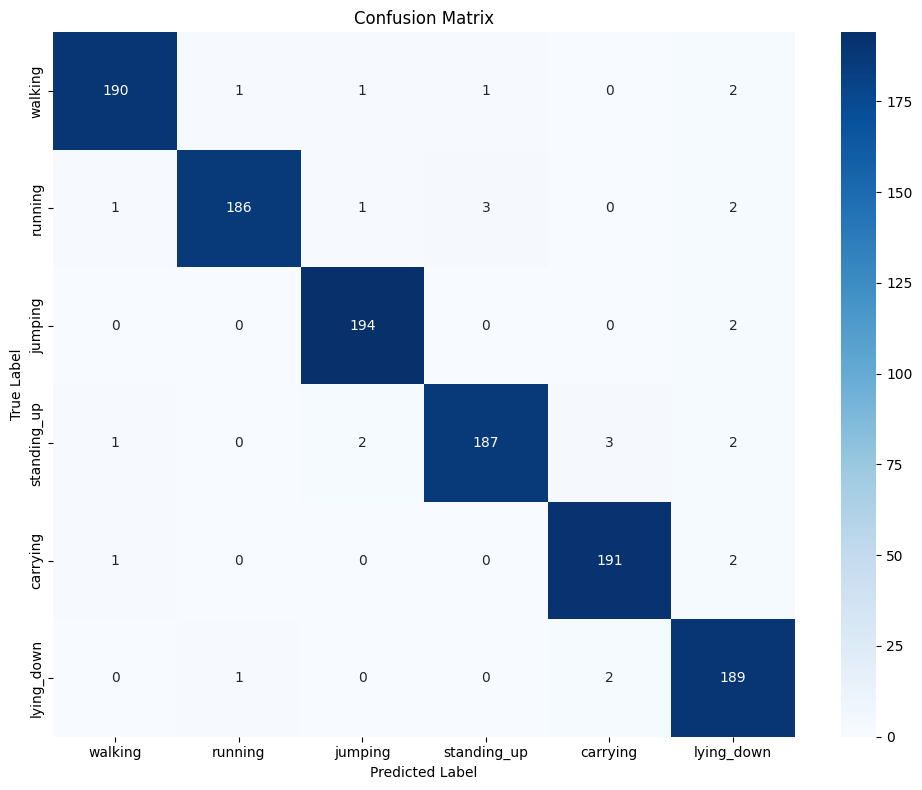

In [29]:
# --- Confusion Matrix ---
if all_labels and all_preds:
    print("\n--- Confusion Matrix ---")
    try:
        cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
        print("Ma trận nhầm lẫn (số lượng):")
        print(cm)

        # Vẽ heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.tight_layout()
        
        # Lưu ảnh
        cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix_notebook.png')
        plt.savefig(cm_path)
        print(f"\nĐã lưu Confusion Matrix vào: {cm_path}")
        plt.show() # Hiển thị trực tiếp trong notebook
    except Exception as e:
        print(f"Lỗi khi tạo hoặc vẽ Confusion Matrix: {e}")
else:
    print("Không có dữ liệu để tạo Confusion Matrix.")


--- Lịch sử Huấn luyện (từ D:\code_etc\Python\_File_code\Pose_estimation_Final\weights\training_history.json) ---
Tải lịch sử huấn luyện thành công.
Đã lưu biểu đồ lịch sử huấn luyện vào: D:\code_etc\Python\_File_code\Pose_estimation_Final\evaluation_results\training_curves_notebook.png


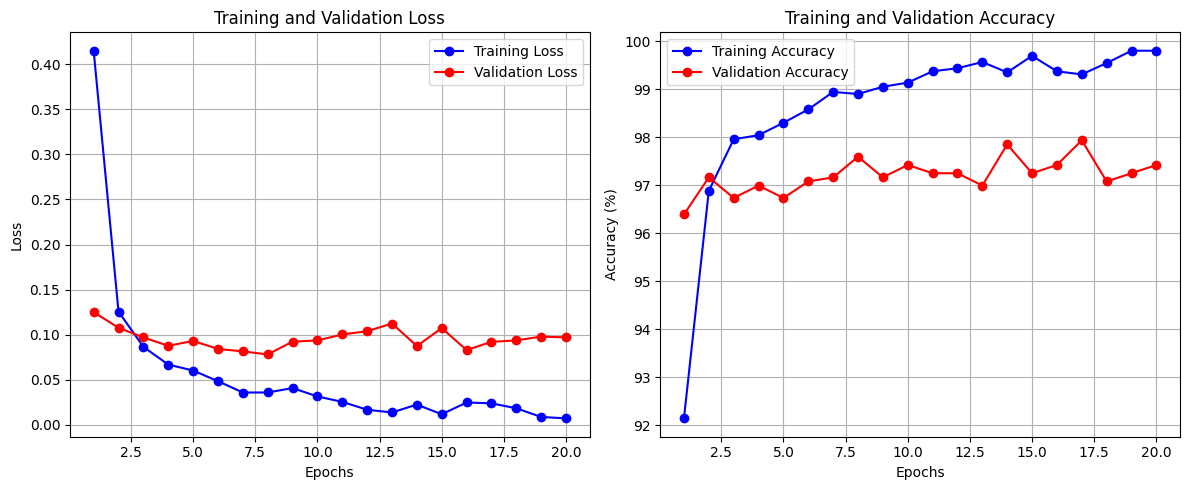


--- Kết thúc đánh giá ---


In [30]:
# --- Biểu đồ Loss và Accuracy ---
print(f"\n--- Lịch sử Huấn luyện (từ {HISTORY_PATH}) ---")
history = None
if os.path.exists(HISTORY_PATH):
    try:
        with open(HISTORY_PATH, 'r') as f:
            history = json.load(f)
        print("Tải lịch sử huấn luyện thành công.")
    except Exception as e:
        print(f"Lỗi khi tải file lịch sử: {e}")
else:
    print(f"Không tìm thấy file lịch sử huấn luyện tại: {HISTORY_PATH}")

if history:
    epochs = range(1, len(history.get('train_loss', [])) + 1)
    if epochs:
        plt.figure(figsize=(12, 5))

        # Vẽ Loss
        plt.subplot(1, 2, 1)
        if 'train_loss' in history and 'val_loss' in history:
            plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
            plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)

        # Vẽ Accuracy
        plt.subplot(1, 2, 2)
        if 'train_acc' in history and 'val_acc' in history:
            plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
            plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.grid(True)

        plt.tight_layout()
        history_plot_path = os.path.join(OUTPUT_DIR, 'training_curves_notebook.png')
        plt.savefig(history_plot_path)
        print(f"Đã lưu biểu đồ lịch sử huấn luyện vào: {history_plot_path}")
        plt.show() # Hiển thị trực tiếp trong notebook
    else:
        print("File lịch sử không có dữ liệu epoch.")
else:
    print("Không có dữ liệu lịch sử để vẽ biểu đồ.")

print("\n--- Kết thúc đánh giá ---")


--- Confusion Matrix ---
Ma trận nhầm lẫn (số lượng):
[[190   1   1   1   0   2]
 [  1 186   1   3   0   2]
 [  0   0 194   0   0   2]
 [  1   0   2 187   3   2]
 [  1   0   0   0 191   2]
 [  0   1   0   0   2 189]]

Đã lưu Confusion Matrix (Percentages) vào: D:\code_etc\Python\_File_code\Pose_estimation_Final\evaluation_results\confusion_matrix_percent_notebook.png


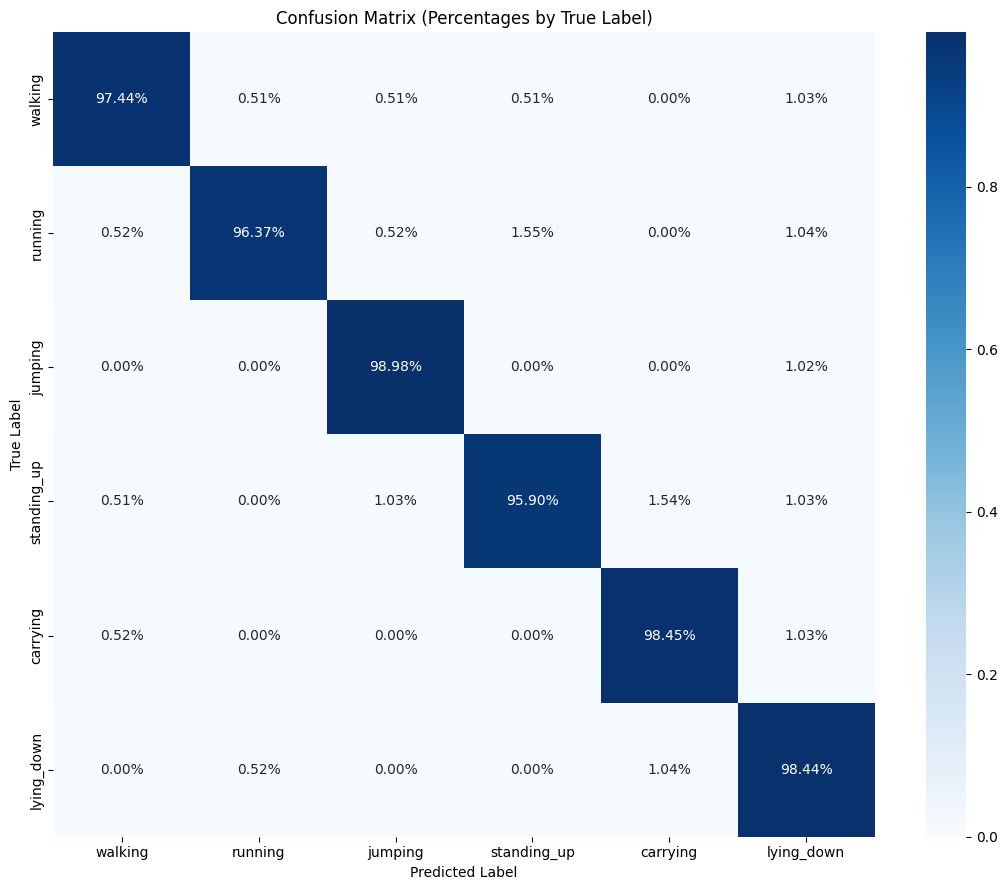

In [31]:
# Ô 8: Tính toán và Vẽ Confusion Matrix (Hiển thị Phần trăm)

# --- Confusion Matrix ---
if all_labels and all_preds:
    print("\n--- Confusion Matrix ---")
    try:
        cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
        print("Ma trận nhầm lẫn (số lượng):")
        print(cm)

        # --- TÍNH TOÁN PHẦN TRĂM ---
        # Chuẩn hóa theo hàng (True Label) để thể hiện tỷ lệ Recall
        cm_sum = np.sum(cm, axis=1, keepdims=True)
        # Xử lý trường hợp chia cho 0 (nếu một lớp không có mẫu nào)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_percent = cm.astype('float') / cm_sum
            cm_percent[np.isnan(cm_percent)] = 0.0 # Thay NaN bằng 0
        # -------------------------

        # --- VẼ HEATMAP PHẦN TRĂM ---
        plt.figure(figsize=(11, 9)) # Tăng kích thước để dễ đọc hơn
        sns.heatmap(
            cm_percent, # <-- Dùng ma trận phần trăm
            annot=True,
            fmt='.2%',  # <-- Định dạng hiển thị là phần trăm (vd: 98.45%)
            cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES,
            annot_kws={"size": 10} # Giảm cỡ chữ nếu cần
        )
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix (Percentages by True Label)') # Cập nhật tiêu đề
        plt.tight_layout()

        # Lưu ảnh
        cm_path = os.path.join(OUTPUT_DIR, 'confusion_matrix_percent_notebook.png') # Đổi tên file lưu
        plt.savefig(cm_path)
        print(f"\nĐã lưu Confusion Matrix (Percentages) vào: {cm_path}")
        plt.show() # Hiển thị trực tiếp trong notebook
        # -----------------------------

    except Exception as e:
        print(f"Lỗi khi tạo hoặc vẽ Confusion Matrix: {e}")
else:
    print("Không có dữ liệu để tạo Confusion Matrix.")